In [1]:
%cd ../..
%run cryptolytic/notebooks/init.ipynb
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import tensorflow as tf
import cryptolytic.util as util
import cryptolytic.start as start
import cryptolytic.viz.plot as plot
import cryptolytic.data.sql as sql
import cryptolytic.data as d
from cryptolytic.util import *
import cryptolytic.data.historical as h
import cryptolytic.model as m
import cryptolytic.model.lstm_framework as lstm

from matplotlib.pylab import rcParams
from IPython.core.display import HTML
from pandas.plotting import register_matplotlib_converters # to stop a warning message


ohclv = ['open', 'high', 'close', 'low', 'volume']
plt.style.use('ggplot')
rcParams['figure.figsize'] = 20,7
start.init()
register_matplotlib_converters()


# Make math readable
HTML("""
<style>
.MathJax {
    font-size: 2rem;
}
</style>""")

/home/me/Documents/Git/Lambda-School-Labs/cryptolytic-ds
Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

### LSTM with Memory Between Batches

>We can gain finer control over when the internal state of the LSTM network is cleared in Keras by making the LSTM layer “stateful”. This means that it can build state over the entire training sequence and even maintain that state if needed to make predictions.

>It requires that the training data not be shuffled when fitting the network. It also requires explicit resetting of the network state after each exposure to the training data (epoch) by calls to model.reset_states(). This means that we must create our own outer loop of epochs and within each epoch call model.fit() and model.reset_states(). For example:

```{python}
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
```

>Finally, when the LSTM layer is constructed, the stateful parameter must be set True and instead of specifying the input dimensions, we must hard code the number of samples in a batch, number of time steps in a sample and number of features in a time step by setting the batch_input_shape parameter. For example:
```
model.add(LSTM(4, batch_input_shape=(batch_size, time_steps, features), stateful=True))
```

In [2]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import yeojohnson

def thing(arg, axis=0):
    x = np.sign(arg) * np.log(np.abs(arg) + 1)
    mu = np.nanmean(x, axis=axis)
    std = np.nanstd(x, axis=axis)
    return x, mu, std

# Version 2 
def normalize(A):
    if isinstance(A, pd.DataFrame) or isinstance(A, pd.Series):
        A = A.values
    if np.ndim(A)==1:
        A = np.expand_dims(A, axis=1)
    A = A.copy()
    x, mu, std = thing(A, axis=0)
    for i in range(A.shape[1]):
        A[:, i] = (x[:, i] - mu[i]) / std[i]
    return A
   
def denormalize(values, df, col=None):
    values = values.copy()
    
    def eq(x, mu, std):
        return np.exp((x * std) + mu) - 1
    
    if np.ndim(values) == 1 and col is not None:
        x, mu, std = thing(df[col])
        return eq(values, mu, std)
    else:
        for i in range(values.shape[1]): 
            x, mu, std = thing(df.iloc[:, i])
            if isinstance(values, pd.DataFrame): 
                values.iloc[:, i] = eq(values.iloc[:, i], mu, std)
            else:
                values[:, i] = eq(values[:, i], mu, std) 
        return values

In [3]:
import os
history_size = 400
input_len = 16000
lahead = 12*3
step = 2
period = 300
to_drop = lahead - 1
input_len = input_len + to_drop
batch_size = 200

df_orig = None
df_orig = d.get_df ({'start':'06-01-2019', 'period':period, 'trading_pair':'btc_usd', 'exchange_id':'bitfinex'},
               n=input_len)

/home/me/Documents/Git/Lambda-School-Labs/cryptolytic-ds/cryptolytic/data/__init__.py:54: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)



In [4]:
import ta
df = df_orig
df = df.sort_index()
df = df._get_numeric_data().drop(["period"], axis=1, errors='ignore')
johnson = df[['volume', 'high_m_low', 'arb_signal']].apply(lambda x: yeojohnson(np.float64(x))[0]).rename(lambda x: x+'_johnson', axis=1)
df = df.filter(regex="(?!timestamp_.*)", axis=1) # filter out timestapm_ metrics
df = ta.add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume").dropna(axis=1)
df_diff = (df - df.shift(1, fill_value=0)).rename(lambda x: x+'_diff', axis=1)
df = pd.concat([df, johnson, df_diff], axis=1)
dataset = normalize(df.values)
target = df.columns.get_loc('close') 
y = dataset[:, target]
history = {'loss' : [], 'val_loss' : []}

/home/me/anaconda3/lib/python3.7/site-packages/ta/trend.py:543: RuntimeWarning:

invalid value encountered in double_scalars

/home/me/anaconda3/lib/python3.7/site-packages/ta/trend.py:547: RuntimeWarning:

invalid value encountered in double_scalars



In [5]:
def windowed(df, target, batch_size, history_size, step, lahead=1, ratio=0.8):
    xs = []
    ys = []
    
    x = dataset
    y = dataset[:, target]

    start = history_size # 1000
    end = df.shape[0] - lahead # 4990
    # 4990 - 1000 = 3990
    for i in range(start, end):
        # grab rows from i, to i+history_size
        indices = range(i-history_size, i, step)
        xs.append(x[indices])
        ys.append(y[i:i+lahead])
        
    xs = np.array(xs)
    ys = np.array(ys)
    
    nrows = xs.shape[0]
    train_size = int(nrows * ratio)
    # make sure the sizes are multiples of the batch size (needed for stateful lstm)
    train_size -= train_size % batch_size
    val_size = nrows - train_size
    val_size -= val_size  % batch_size
    total_size = train_size + val_size
    xs = xs[:total_size]
    ys = ys[:total_size]
    
    return xs[:train_size], ys[:train_size], xs[train_size:], ys[train_size:]

In [6]:
x_train, y_train, x_val, y_val = windowed(dataset, target, batch_size, history_size, step, lahead)
mapl(lambda x: x.shape, [x_train, y_train, x_val, y_val])

[(12400, 200, 115), (12400, 36), (3000, 200, 115), (3000, 36)]

In [7]:
print ('Single window of past history : {}'.format(x_train[0].shape))
print ('\n Number of candles to predict : {}'.format(y_train[0].shape))

Single window of past history : (200, 115)

 Number of candles to predict : (36,)


In [8]:
# import tensorflow as tf
# BUFFER_SIZE = 10_000
# BATCH_SIZE = 250
# train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# 
# val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# val_data = val_data.batch(BATCH_SIZE).repeat()

In [9]:
from dtw import dtw

# x = df['close']
# y = df['close'].shift(1)
# manhattan_distance = lambda x, y: np.abs(x - y)

# d, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=manhattan_distance)

- For areas lacking data, can use masking 

inputs[:, 3, :] = 0. # for areas without a timestep, set to the mask value
inputs[:, 5, :] = 0.
model.add(tf.keras.layers.Masking(mask_value=0.,
                                  input_shape=(timesteps, features)))

In [10]:
np.random.rand()

0.7897534858207987

In [16]:
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.models as models
import tensorflow.keras.constraints as constraints
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.layers import Conv1D, Activation, Add, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform, glorot_uniform


def conv_block(X, filters, f, stage,block, strides=2):
    """
    X -- input tensor
    f -- interger specify shape of conv window
    stage - integer, used to named layers, depending on position in network.
    stride -- stride
    """
    conv_base_name = 'conv' + str(stage) + block
    bn_base_name = 'bn' + str(stage) + block
    
    f1, f2, f3 = filters
    
    X_shortcut = X
    X = Conv1D(f1, kernel_size=1, strides=strides, name=conv_base_name + '_1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Activation('tanh')(X)
    
    X = Conv1D(f2, kernel_size=f, strides=1, padding='same', name=conv_base_name + '_2', 
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = Activation('tanh')(X)
    
    X = Conv1D(f3, kernel_size=1, strides=1, padding='valid', name=conv_base_name + '_3', 
               kernel_initializer=glorot_uniform(seed=0))(X)
    # skip connection
    X_shortcut = Conv1D(f3, kernel_size=1, strides=strides, padding='valid', name=conv_base_name + '_4', 
               kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    
    assert tf.keras.backend.int_shape(X) == tf.keras.backend.int_shape(X_shortcut)
    X = Add()([X, X_shortcut])
    X = Activation('tanh')(X)

    return X

def identity_block(X, f, filters, stage, block, strides=2):
    """
    X -- input tensor
    f -- interger specify shape of conv window
    stage - integer, used to named layers, depending on position in network.
    stride -- stride
    """
    conv_base_name = 'conv' + str(stage) + block
    bn_base_name = 'bn' + str(stage) + block
    
    f1, f2, f3 = filters
    
    X_shortcut = X
    X = Conv1D(f1, kernel_size=1, strides=strides, name=conv_base_name + '_1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Activation('tanh')(X)
    
    X = Conv1D(f2, kernel_size=f, strides=1, padding='same', name=conv_base_name + '_2', 
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = Activation('tanh')(X)
    
    X = Conv1D(f3, kernel_size=1, strides=strides, padding='valid', name=conv_base_name + '_3', 
               kernel_initializer=glorot_uniform(seed=0))(X)
    # skip connection, without also convolving x_shortcut
    assert tf.keras.backend.int_shape(X) == tf.keras.backend.int_shape(X_shortcut)
    X = Add()([X, X_shortcut])
    X = Activation('tanh')(X)
    return X

#class attention_layer(layers.Layer):
#    #print([var.name for var in attn_layer.trainable_variables])
#    def __init__(self, attention_size):
#        super(attention_layer, self).__init__()
#        self.attention_size = attention_size
#        self.b_omega = tf.Variable(tf.random.normal([attention_size], stddev=0.1))
#        self.u_omega = tf.Variable(tf.random.normal([attention_size], stddev=0.1))
#        
#    def build(self, input_shape):
#        self.w_omega = tf.Variable(tf.random.normal([input_shape[-1], self.attention_size], stddev=0.1))
#        
#    def call(self, _in):
#        v = tf.tanh(tf.tensordot(_in, self.w_omega, axes=1) + self.b_omega)
#        vu = tf.tensordot(v, self.u_omega, axes=1, name='vu') # B,T shape
#        alphas = tf.nn.softmax(vu, name='alphas')
#        
#        output = tf.reduce_sum(_in * tf.expand_dims(alphas, -1), 1)
#        return output

class Tuner(tf.keras.Model):
    def __init__(self):
        super(Tuner, self).__init__()
        #self.classifier = Dense()
            
    def build(self):
            pass
        
    def call(self, inputs):
        x = self.block_1(inputs)
        x = self.block_2(x)
        
        pass
    pass

    
def create_model(x_train, params):
    attention_size = 5
    input_shape = x_train.shape[-2:]
    X_input = Input(input_shape, batch_size=batch_size)
    X = X_input
    X = layers.ZeroPadding1D(padding=2)(X)
#    X = layers.TimeDistributed(Dense(input_shape[-1], kernel_constraint=constraints.max_norm(1.0), activation='tanh'))(X)
    X = Conv1D(filters=params.filters1, kernel_size=6, strides=1, name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.GaussianNoise(params.noise1)(X)
    #X = layers.AveragePooling1D(2, strides=1)(X)
    X = conv_block(X, f=3, filters=params.filtershape1, stage=2, block='a', strides=2)
    X = layers.GaussianNoise(params.noise1)(X)
    X = identity_block(X, f=3, filters=params.filtershape1, stage=2, block='b', strides=1)
    X = layers.GaussianNoise(params.noise1)(X)
    X = identity_block(X, f=3, filters=params.filtershape1, stage=2, block='c', strides=1)
    
    print(X.get_shape())
    print(X_input.get_shape())
    #X = layers.concatenate([X, X_input])
    
   # X = layers.AveragePooling1D(2, name="avg_pool")(X)
    
#    rnn_cells = [tf.keras.layers.LSTMCell(128) for _ in range(2)]
#    stacked_lstm = tf.keras.layers.StackedRNNCells(rnn_cells)
#    lstm_layer = tf.keras.layers.RNN(stacked_lstm)
#    X = lstm_layer(X)
 
    X = layers.Flatten()(X)
    X = Dense(256)(X)
    X = Dense(lahead, kernel_initializer=glorot_uniform(seed=0))(X)
    
    model = Model(inputs=X_input, outputs=X, name='model1')
    model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001))
    return model

In [19]:
from cryptolytic.util import *
        
    
def fit_model(model, inputX, inputy):
    epochs = 5
    # batch size higher than 1 c  epochs = 10
    for i in range(epochs):
        model.fit(inputX,
                  inputy, 
                  batch_size=batch_size,
                  epochs=1,
                  verbose=1,
                  use_multiprocessing=True,
                  shuffle=False,
                  workers=4,
                  validation_data = (x_val, y_val))
        history['loss'].append(model.history.history['loss'])
        history['val_loss'].append(model.history.history['val_loss'])
#        model.reset_states()
    #pred = transformer.denormalize(model.predict(x_val)[:, 0], df, 'close')
    #pred_history.append(pred)
        
    return model
    
def save_model(model, folder, params=None):
    path = f'models/{folder}'
    if not os.path.exists(path):
        os.mkdir(path)
    filename = os.path.join(path, 'model_' + str(np.random.rand()) + '.h5')
    if os.path.exists(filename):
        return save_model(model)
    if params is not None:
        param_path = os.path.join(path, 'model_params.csv')
        pd.DataFrame(params).to_csv(param_path)
        
    model.save(filename)
    print('Saved model')
    
def load_all_models(folder):
    models = []
    params = []
    path = f'models/{folder}'
    for m in os.listdir(path):
        if m.endswith('.csv'):
            params.append(pd.read_csv(m))
        if not m.endswith('.h5'):
            continue
        m = tf.keras.models.load_model(m)
        models.append(m)
        print('Loaded %s' % path)
    return models, params

def stacked_dataset(models, inputX):
    stackX = None
    for model in models:
        yhat = model.predict(inputX, verbose=0)
        #stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilties]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

def fit_stacked_model(models, inputX, inputy):
    stackedX = stacked_dataset(models, inputX)
    # fit model
    model = create_model(inputX)
    fit_model(model, inputX, inputy)
    return model

def stacked_prediction(models, model, inputX):
    stackedX = stacked_dataset(models, inputX)
    yhat = model.predict(stackedX)
    return yhat

def endingly():
    models, params = load_all_models('example')
    model = fit_stacked_model(models, x_train, y_train)
    preds = stacked_prediction(models, model, x_train)
    evaluate_models(models)
    return preds

def hyperparameter(inputX, inputy):
    filtershape1 = 32 + 16 * np.random.randint(0, 6)
    filtershape2 = 32 + 16 * np.random.randint(0, 6)
    
    params = adict(
        filters1 = 32 + 16 * np.random.randint(0, 5),
        noise1 = np.random.uniform(high=0.01),
        filtershape1 = [filtershape1, filtershape1, filtershape1*2],
        filtershape2 = [filtershape2, filtershape2, filtershape2*2]
    )
    print(params)
    model = create_model(inputX, params)
    fit_model(model, inputX, inputy)
    save_model(model, 'filter', params=params)
    return model
                 
def run_tuning():
    models = []
    for i in range(50):
        models.append(hyperparameter(x_train, y_train))
    return models

   
def evaluate_models(models):
    for m in models:
        _, acc = model.evaluate(x_val, y_val)
    


In [ ]:
{'filters1': 32, 'noise1': 0.007044669933974564, 'filtershape1': [48, 48, 96], 'filtershape2': [64, 64, 128]}
{'filters1': 96, 'noise1': 0.0067625880989959294, 'filtershape1': [48, 48, 96], 'filtershape2': [32, 32, 64]}
{'filters1': 64, 'noise1': 0.002182333479015578, 'filtershape1': [32, 32, 64], 'filtershape2': [48, 48, 96]}
{'filters1': 48, 'noise1': 0.004816923153178217, 'filtershape1': [48, 48, 96], 'filtershape2': [32, 32, 64]}
{'filters1': 32, 'noise1': 0.0004049353180822357, 'filtershape1': [64, 64, 128], 'filtershape2': [32, 32, 64]}
{'filters1': 64, 'noise1': 0.0015181074459694344, 'filtershape1': [48, 48, 96], 'filtershape2': [64, 64, 128]}


In [ ]:
 np.mean([32, 96, 64, 48, 32, 64])

In [ ]:
models = run_tuning()

{'filters1': 96, 'noise1': 0.0023524256572771854, 'filtershape1': [64, 64, 128], 'filtershape2': [48, 48, 96]}
(200, 100, 128)
(200, 200, 115)
Train on 12400 samples, validate on 3000 samples
12400/12400 [==============================] - 56s 5ms/sample - loss: 1.0337 - val_loss: 0.7323
Train on 12400 samples, validate on 3000 samples
12400/12400 [==============================] - 53s 4ms/sample - loss: 0.5027 - val_loss: 0.5628
Train on 12400 samples, validate on 3000 samples
12400/12400 [==============================] - 51s 4ms/sample - loss: 0.3414 - val_loss: 0.4160
Train on 12400 samples, validate on 3000 samples
12400/12400 [==============================] - 53s 4ms/sample - loss: 0.2604 - val_loss: 0.4821
Train on 12400 samples, validate on 3000 samples
12400/12400 [==============================] - 53s 4ms/sample - loss: 0.2079 - val_loss: 0.3329
Saved model
{'filters1': 32, 'noise1': 0.0073190999447795444, 'filtershape1': [32, 32, 64], 'filtershape2': [32, 32, 64]}
(200, 100,

In [ ]:
models

In [ ]:
evaluate_models(models)

In [ ]:
endingly()

In [ ]:
model = create_model(x_train)
history = {'loss':[],'val_loss':[]}

In [ ]:
model.summary()

In [ ]:
model = run_model()

In [ ]:
model.evaluate(x_val, y_val)

In [ ]:
from tensorflow.keras.utils.vis_utils import model_to_dot


In [ ]:
dataset[:, target]

In [ ]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
        label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
            label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()
    
def plot_train_history(loss, val_loss, title):
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    
    plt.show()

    
plot_train_history(history['loss'], history['val_loss'], 'Multi Step Training and validation loss') 

In [ ]:
history[0]

# Predictions on the train set

In [ ]:
# preds = denormalize(model.predict(x_train)[:, 0], df, 'close')
#preds = denormalize(df, transformer)
#preds = denormalize(model.predict(x_train)[:, 0])

In [23]:
model = models[0]

In [25]:
model

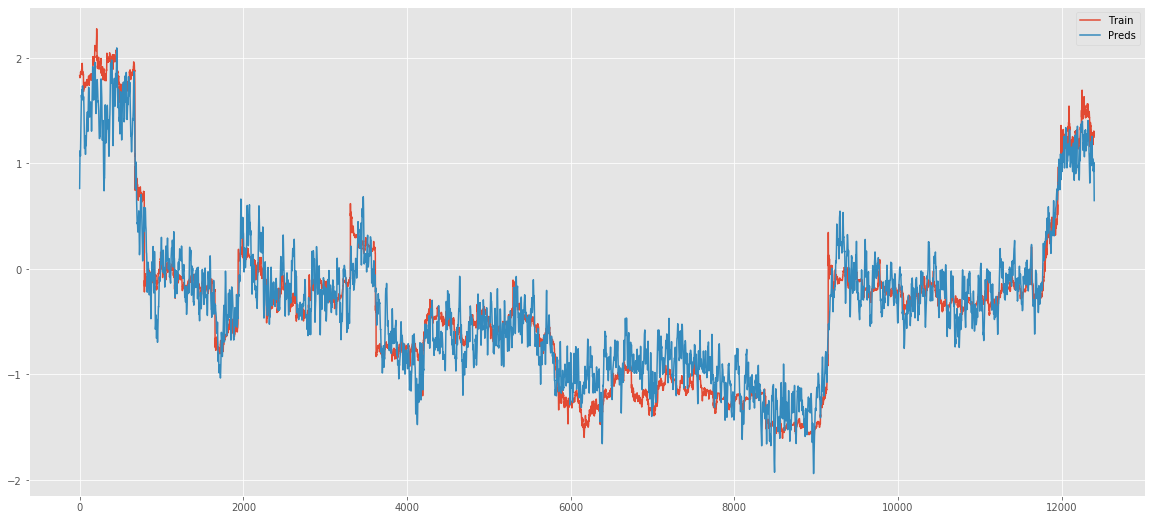

In [26]:
rcParams['figure.figsize'] = 20,9
preds = model.predict(x_train)[:, 0]
n = len(preds)
h = history_size
hn = n+history_size
yo= len(x_val)+history_size
z = yo
modman = len(df)% batch_size
w = z + len(df)%modman

# plt.plot(range(n), d.denoise(df['close'][h:hn], 400), label='actual', color='green')
# plt.plot(range(n), d.denoise(preds[:n], 5), label='predicted');
# plt.plot(range(n), df.close_mean.values[h:hn], label='Mean')

plt.plot(y_train[:, 0], label='Train')
plt.plot(d.denoise(preds, 5), label='Preds')
plt.legend();

# Predictions on validation set

In [ ]:
val_preds = denormalize(model.predict(x_val)[:, 0], df, 'close')

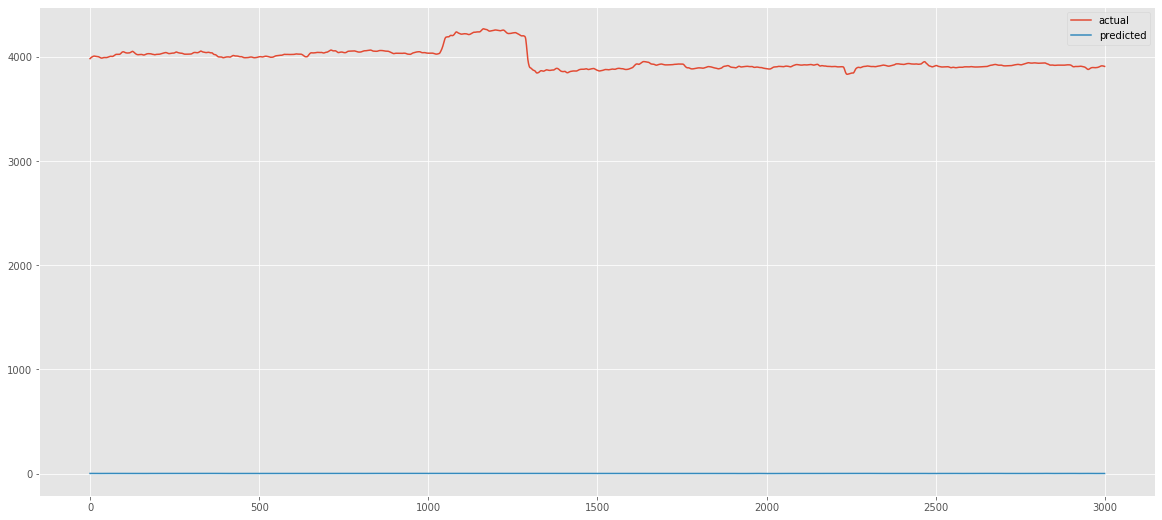

In [28]:
y_actual = denormalize(y_val[:, 0], df, 'close')
#preds = model.predict(x_val)[:, 0]
val_preds = model.predict(x_val)[:, 0]
#y_actual = y_val[:, 0]
val_n = len(val_preds)
hn = n+history_size
plt.plot(range(val_n), d.denoise(y_actual, 5), label='actual')
#plt.plot(range(val_n), df['close'].iloc[-val_n:], label='actual')
plt.plot(range(val_n), d.denoise(val_preds, 5), label='predicted');
plt.legend();

In [ ]:
plt.plot(range(val_n), d.denoise(val_preds[1], 5), label='predicted');

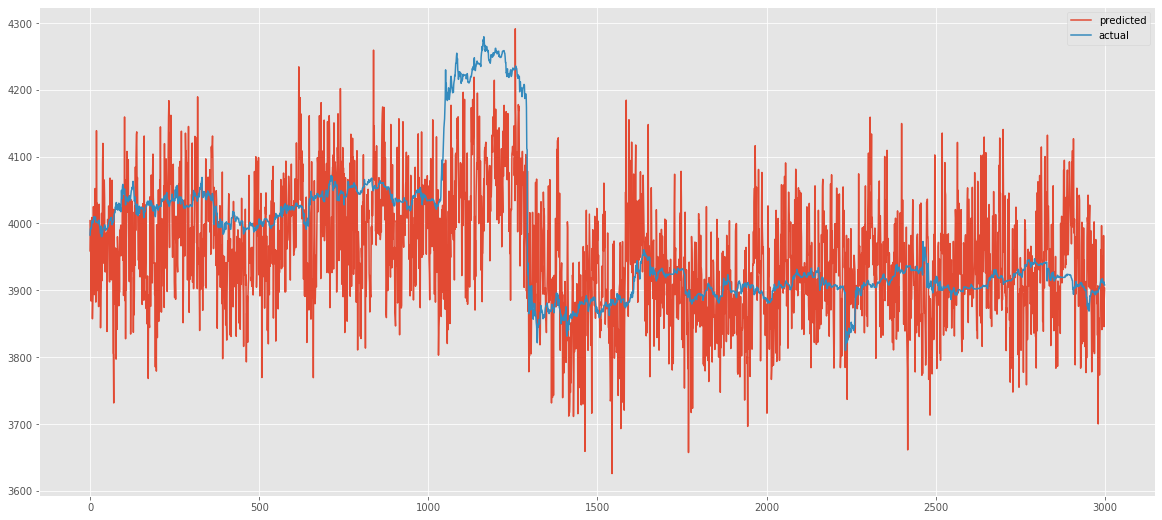

In [29]:
yo = denormalize(model.predict(x_val)[:, 0], df, 'close')
y_actual = denormalize(y_val[:, 0], df, 'close')
plt.plot(yo, label='predicted')
plt.plot(y_actual, label='actual')
plt.legend()